In [1]:
from jax import lax, numpy as jnp
from jax import vmap
import numpy as np
import tasks
import plots

In [2]:
from jax import numpy as jnp

# Original tensor
x = jnp.array([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
], dtype=jnp.float32)

# Define the padding size
Rk = 1

# Perform circular padding
x_pad = jnp.pad(x, pad_width=((Rk, Rk), (Rk, Rk)), mode='wrap')

print(x_pad)

[[9. 7. 8. 9. 7.]
 [3. 1. 2. 3. 1.]
 [6. 4. 5. 6. 4.]
 [9. 7. 8. 9. 7.]
 [3. 1. 2. 3. 1.]]


In [3]:
radius = 2
# kernel shape OIHW
k = jnp.ones((3,1,2*radius+1,2*radius+1)) # 3 output channels, 1 input channel, height 3, width 3
k = k / (jnp.sum(k, axis=(2,3))[:,:,None,None])
k = k * jnp.array([0.99,0.985, 0.985])[:, None, None, None]
# image shape NIHW

# start with zeros
initial_error_grid = jnp.zeros((1, 3,50,50)) # 1 batch, 3 channels, 50 pixels height and width


In [4]:
def circular_pad_channel(channel, radius):
    return jnp.pad(channel, pad_width=((radius, radius), (radius, radius)), mode='wrap')

vmap_circular_pad = vmap(vmap(circular_pad_channel, in_axes=(0,None)), in_axes=(0,None)) # ugly, but I want to pad each channel in each batch independently. vmpa only maps to one dimension, so need to nest it to apply for channels and batches

In [5]:
k.shape

(3, 1, 5, 5)

In [6]:
def CA(carry, inputs, params):
    radius, kernel = params
    error_signals = inputs # basically the new error signals coming
    error_grid = carry # the previous grid of diffused errors
    error_grid_pad = vmap_circular_pad(error_grid, radius)
    new_error_grid = lax.conv_general_dilated(lhs = error_grid_pad,
                                         rhs = kernel,
                                         window_strides=(1,1),
                                         padding='VALID', # valid means without padding, have alredy added the necessary circular padding
                                         dimension_numbers=('NCHW', 'OIHW', 'NCHW'), # dimensions of image, kernel, output
                                         feature_group_count=3
    )
    new_error_grid += error_signals

    return new_error_grid, new_error_grid

In [7]:
# Create an array of zeros with shape (1, 3, 50, 50)
error_signal = jnp.zeros((1, 3, 50, 50), dtype=jnp.float32)

# Set the entries at position [:, :, 25, 25] to 255
error_signal = error_signal.at[:, :, 25, 25].set(255)


In [8]:
#Test
new_error_grid, new_error_grid = CA(initial_error_grid, error_signal, (radius,k))
new_error_grid.shape

(1, 3, 50, 50)

In [9]:
# test for 3 time steps (the first one, 0, creates the initial state)
params=(radius,k)
error_signal = jnp.zeros((4,1, 3, 50, 50), dtype=jnp.float32)

# Set the entries at position [:, :, 25, 25] to 255
error_signal = error_signal.at[0,:, :, 25, 25].set(255)
_, error_grid = lax.scan(
    lambda carry, input: CA(carry, input, params),
    initial_error_grid,
    error_signal
)
error_grid.shape

(4, 1, 3, 50, 50)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


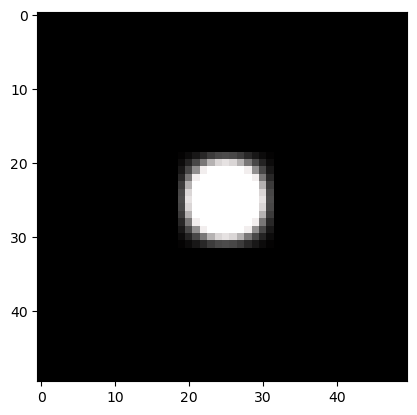

In [10]:
import matplotlib.pyplot as plt
plt.imshow(jnp.transpose(error_grid[3,0], (1,2,0)))

In [11]:
print(initial_error_grid.shape)

(1, 3, 50, 50)


In [12]:

import jax
import jax.numpy as jnp
import numpy as np

def twod_grid_jax(gridsize, n_cells):
    s = gridsize
    total_cells = s * s
    if n_cells > total_cells:
        raise ValueError("n_cells cannot be greater than the total number of cells in the grid.")
    
    x = jnp.tile(jnp.arange(s), s) / s
    y = jnp.repeat(jnp.arange(s), s) / s
    
    grid_positions = jnp.column_stack((x, y))
    
    key = jax.random.PRNGKey(0)
    selected_indices = jax.random.choice(key, total_cells, shape=(n_cells,), replace=False)
    selected_positions = grid_positions[selected_indices]
    
    return grid_positions, selected_positions

# Example usage
gridsize = 5
n_cells = 10
grid, selected_cells = twod_grid_jax(gridsize, n_cells)
print("Grid positions:\n", grid)
print("Selected cell positions:\n", selected_cells)

Grid positions:
 [[0.  0. ]
 [0.2 0. ]
 [0.4 0. ]
 [0.6 0. ]
 [0.8 0. ]
 [0.  0.2]
 [0.2 0.2]
 [0.4 0.2]
 [0.6 0.2]
 [0.8 0.2]
 [0.  0.4]
 [0.2 0.4]
 [0.4 0.4]
 [0.6 0.4]
 [0.8 0.4]
 [0.  0.6]
 [0.2 0.6]
 [0.4 0.6]
 [0.6 0.6]
 [0.8 0.6]
 [0.  0.8]
 [0.2 0.8]
 [0.4 0.8]
 [0.6 0.8]
 [0.8 0.8]]
Selected cell positions:
 [[0.  0.4]
 [0.8 0.4]
 [0.4 0.8]
 [0.2 0.8]
 [0.6 0.2]
 [0.2 0.4]
 [0.  0.2]
 [0.8 0.8]
 [0.  0.8]
 [0.4 0.4]]


In [13]:
selected_cells

Array([[0. , 0.4],
       [0.8, 0.4],
       [0.4, 0.8],
       [0.2, 0.8],
       [0.6, 0.2],
       [0.2, 0.4],
       [0. , 0.2],
       [0.8, 0.8],
       [0. , 0.8],
       [0.4, 0.4]], dtype=float32)

In [14]:
import jax
import jax.numpy as jnp

# Step 1: Initialize the (n, n) grid array with zeros
n = 5  # example grid size
grid = jnp.zeros((n, n))

# Step 2: Define the input array and the list of index tuples
input_array = jnp.array([10, 20, 30, 40])  # example input array
indices = [(0, 1), (2, 3), (4, 0), (1, 4)]  # example list of tuples

# Step 3: Convert the list of tuples into two separate lists for row and column indices
rows, cols = zip(*indices)

# Step 4: Use jax.ops.index_update to modify the grid array
updated_grid = grid.at[rows, cols].set(input_array)

# Printing the results
print("Initial Grid:\n", grid)
print("Updated Grid:\n", updated_grid)

Initial Grid:
 [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Updated Grid:
 [[ 0. 10.  0.  0.  0.]
 [ 0.  0.  0.  0. 40.]
 [ 0.  0.  0. 20.  0.]
 [ 0.  0.  0.  0.  0.]
 [30.  0.  0.  0.  0.]]


In [15]:
import jax
import jax.numpy as jnp

# Step 1: Initialize the (n, n) grid array with zeros
n = 5  # example grid size
grid = jnp.zeros((n, n))

# Step 2: Define the input array and the list of index tuples
input_array = jnp.array([10, 20, 30, 40])  # example input array
indices = [(0, 1), (2, 3), (4, 0), (1, 4)]  # example list of tuples

# Step 3: Convert the list of tuples into two separate lists for row and column indices
rows, cols = zip(*indices)

# Step 4: Use jax.ops.index_add to add the input array values to the grid array at specified indices
updated_grid = grid.at[rows, cols].add(input_array)

# Printing the results
print("Initial Grid:\n", grid)
print("Updated Grid:\n", updated_grid)

Initial Grid:
 [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Updated Grid:
 [[ 0. 10.  0.  0.  0.]
 [ 0.  0.  0.  0. 40.]
 [ 0.  0.  0. 20.  0.]
 [ 0.  0.  0.  0.  0.]
 [30.  0.  0.  0.  0.]]


In [16]:
updated_grid = updated_grid.at[rows, cols].add(input_array)

In [26]:
import jax
import jax.numpy as jnp
from jax import lax

# Step 1: Initialize the (3, 1, 5, 5) grid array with zeros
grid = jnp.zeros((3, 1, 5, 5))

# Step 2: Define the input array with a time dimension (t, m)
input_array = jnp.array([
    [10, 20, 30, 40],  # t = 0
    [5, 15, 25, 35],   # t = 1
    [1, 2, 3, 4]       # t = 2
])  # example input array with time dimension

# Step 3: Define the list of index tuples
indices = jnp.array([(0, 1), (2, 3), (4, 0), (1, 4)])  # example list of tuples
print(indices.shape)
# Convert the list of tuples into two separate lists for row and column indices
rows, cols = zip(*indices)

# Step 4: Define a function to update the grid at each time step
def update_grid(grid, input_t):
    # Use broadcasting along the first dimension
    updated_grid = grid.at[:, 0, rows, cols].add(input_t)
    return updated_grid, updated_grid

# Step 5: Use jax.lax.scan to apply the update function over the time dimension
initial_state = grid
time_dimension = input_array.shape[0]

# lax.scan takes the function, initial state, and the sequence to iterate over (input_array in this case)
final_grid, grids_over_time = lax.scan(update_grid, initial_state, input_array)

# Printing the results
print("Initial Grid:\n", grid)
print("Grids over Time:\n", grids_over_time)
print("Final Grid after all time steps:\n", final_grid)



(4, 2)
Initial Grid:
 [[[[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]]


 [[[0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]
   [0. 0. 0. 0. 0.]]]]
Grids over Time:
 [[[[[ 0. 10.  0.  0.  0.]
    [ 0.  0.  0.  0. 40.]
    [ 0.  0.  0. 20.  0.]
    [ 0.  0.  0.  0.  0.]
    [30.  0.  0.  0.  0.]]]


  [[[ 0. 10.  0.  0.  0.]
    [ 0.  0.  0.  0. 40.]
    [ 0.  0.  0. 20.  0.]
    [ 0.  0.  0.  0.  0.]
    [30.  0.  0.  0.  0.]]]


  [[[ 0. 10.  0.  0.  0.]
    [ 0.  0.  0.  0. 40.]
    [ 0.  0.  0. 20.  0.]
    [ 0.  0.  0.  0.  0.]
    [30.  0.  0.  0.  0.]]]]



 [[[[ 0. 15.  0.  0.  0.]
    [ 0.  0.  0.  0. 75.]
    [ 0.  0.  0. 35.  0.]
    [ 0.  0.  0.  0.  0.]
    [55.  0.  0.  0.  0.]]]


  [[[ 0. 15.  0.  0.  0.]
    [ 0.  0.  0.  0. 75.]
    [ 0.  0.  0. 35.  0.]
    [ 0.  0.  0.  0.  0.]
    [55

In [21]:
error_signal = final_grid[:, 0, rows, cols]

In [25]:
error_signal

Array([[16., 37., 58., 79.],
       [16., 37., 58., 79.],
       [16., 37., 58., 79.]], dtype=float32)

In [37]:
# Step 1: Initialize the (3, 1, 5, 5) grid array with zeros
grid = jnp.zeros((5, 1, 2, 2))

# Step 2: Define the input array with a time dimension (t, m)
input_array = jnp.array([
    [[10, 20, 30], [10, 20, 30], [10, 20, 30],[10, 20, 30],[10, 20, 30]],  # t = 0
    [[5, 15, 25],  [5, 15, 25],[10, 20, 30],[10, 20, 30],[10, 20, 30] ],# t = 1
    [[1, 2, 3], [1, 2, 3],[10, 20, 30],[10, 20, 30],[10, 20, 30]]   # t = 2
])  # example input array with time dimension

print(input_array.shape)
# Step 3: Define the list of index tuples
indices = jnp.array([(0, 1), (0,0), (1, 0)])  # example list of tuples
print(indices.shape)
# Convert the list of tuples into two separate lists for row and column indices
rows, cols = indices[:, 0], indices[:, 1]

# Step 4: Define a function to update the grid at each time step
def update_grid(grid, input_t):
    # Use broadcasting along the first dimension
    updated_grid = grid.at[:, 0, rows, cols].add(input_t)
    return updated_grid, updated_grid

# Step 5: Use jax.lax.scan to apply the update function over the time dimension
initial_state = grid
time_dimension = input_array.shape[0]

# lax.scan takes the function, initial state, and the sequence to iterate over (input_array in this case)
final_grid, grids_over_time = lax.scan(update_grid, initial_state, input_array)

# Printing the results
print("Initial Grid:\n", grid)
print("Grids over Time:\n", grids_over_time)
print("Final Grid after all time steps:\n", final_grid)


(3, 5, 3)
(3, 2)
Initial Grid:
 [[[[0. 0.]
   [0. 0.]]]


 [[[0. 0.]
   [0. 0.]]]


 [[[0. 0.]
   [0. 0.]]]


 [[[0. 0.]
   [0. 0.]]]


 [[[0. 0.]
   [0. 0.]]]]
Grids over Time:
 [[[[[20. 10.]
    [30.  0.]]]


  [[[20. 10.]
    [30.  0.]]]


  [[[20. 10.]
    [30.  0.]]]


  [[[20. 10.]
    [30.  0.]]]


  [[[20. 10.]
    [30.  0.]]]]



 [[[[35. 15.]
    [55.  0.]]]


  [[[35. 15.]
    [55.  0.]]]


  [[[40. 20.]
    [60.  0.]]]


  [[[40. 20.]
    [60.  0.]]]


  [[[40. 20.]
    [60.  0.]]]]



 [[[[37. 16.]
    [58.  0.]]]


  [[[37. 16.]
    [58.  0.]]]


  [[[60. 30.]
    [90.  0.]]]


  [[[60. 30.]
    [90.  0.]]]


  [[[60. 30.]
    [90.  0.]]]]]
Final Grid after all time steps:
 [[[[37. 16.]
   [58.  0.]]]


 [[[37. 16.]
   [58.  0.]]]


 [[[60. 30.]
   [90.  0.]]]


 [[[60. 30.]
   [90.  0.]]]


 [[[60. 30.]
   [90.  0.]]]]


In [29]:
import jax.numpy as jnp


# Example data
n_b, d = 3, 4  # Dimensions for the main array
n = 5  # Number of index pairs

main_array = jnp.zeros((n_b, 1, d, d))
index_array = jnp.array([[0, 1], [2, 3], [1, 1], [0, 0], [3, 2]])  # Shape (n, 2)

# Extract rows and cols from index_array
rows, cols = index_array[:, 0], index_array[:, 1]

# Define a function to update the grid at each time step
def update_grid(grid, input_t):
    # Use broadcasting along the first dimension
    updated_grid = grid.at[:, 0, rows, cols].add(input_t)
    return updated_grid, updated_grid

# Input tensor with the same batch size as main_array
input_t = jnp.ones((n_b, n))

# Update the main array using the input tensor
main_array, updated_grid = update_grid(main_array, input_t)

# Print the updated main array
print(updated_grid)


[[[[1. 1. 0. 0.]
   [0. 1. 0. 0.]
   [0. 0. 0. 1.]
   [0. 0. 1. 0.]]]


 [[[1. 1. 0. 0.]
   [0. 1. 0. 0.]
   [0. 0. 0. 1.]
   [0. 0. 1. 0.]]]


 [[[1. 1. 0. 0.]
   [0. 1. 0. 0.]
   [0. 0. 0. 1.]
   [0. 0. 1. 0.]]]]
